In [2]:
pip install mahotas

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------------ --------------------------- 0.5/1.7 MB 2.1 MB/s eta 0:00:01
   ------------------ --------------------- 0.8/1.7 MB 1.9 MB/s eta 0:00:01
   ------------------------ --------------- 1.0/1.7 MB 1.8 MB/s eta 0:00:01
   ------------------------------------ --- 1.6/1.7 MB 1.8 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 1.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
pip install streamlit


   ---------------------------------------- 0.0/8.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.6 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.6 MB 1.5 MB/s eta 0:00:06
   --- ------------------------------------ 0.8/8.6 MB 1.6 MB/s eta 0:00:05
   ------ --------------------------------- 1.3/8.6 MB 1.7 MB/s eta 0:00:05
   ------- -------------------------------- 1.6/8.6 MB 1.7 MB/s eta 0:00:05
   --------- ------------------------------ 2.1/8.6 MB 1.8 MB/s eta 0:00:04
   ---------- ----------------------------- 2.4/8.6 MB 1.8 MB/s eta 0:00:04
   ------------ --------------------------- 2.6/8.6 MB 1.8 MB/s eta 0:00:04
   -------------- ------------------------- 3.1/8.6 MB 1.8 MB/s eta 0:00:04
   --------------- ------------------------ 3.4/8.6 MB 1.8 MB/s eta 0:00:03
   ------------------ --------------------- 3.9/8.6 MB 1.8 MB/s eta 0:00:03
   ------------------- -------------------- 4.2/8.6 MB 1.8 MB/s eta 0:00:03
   ------------------- --


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


[STATUS] Started extracting features (Haralick + Color)...
Processing Image - 1 in jahe
Processing Image - 2 in jahe
Processing Image - 3 in jahe
Processing Image - 1 in kunyit
Processing Image - 2 in kunyit
Processing Image - 3 in kunyit
Processing Image - 1 in lengkuas
Processing Image - 2 in lengkuas
Processing Image - 3 in lengkuas
Processing Image - 1 in sirih
Processing Image - 2 in sirih
Processing Image - 3 in sirih
Training features: (12, 397)
Training labels: (12,)
[STATUS] Creating the classifier...
[STATUS] Fitting data/label to model...


c:\Users\ERIKA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



[STATUS] Starting testing phase...

File: test_1.jpg | Predicted Label: jahe
File: test_4.jpg | Predicted Label: kunyit
File: test_5.jpg | Predicted Label: kunyit
File: test_6.jpg | Predicted Label: lengkuas


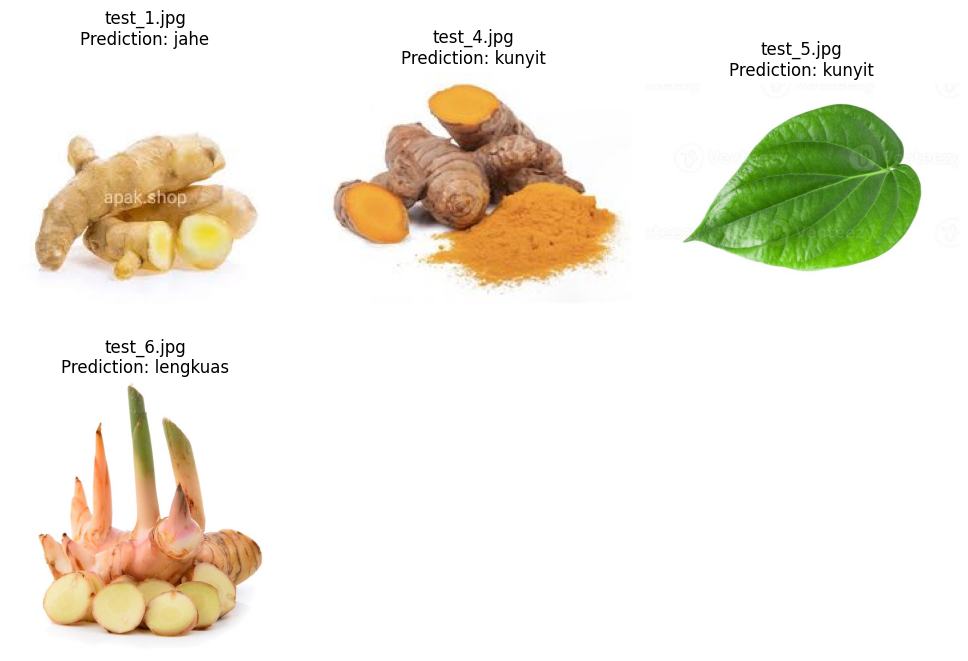

In [9]:
import cv2
import numpy as np
import os
import glob
import mahotas as mt
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import streamlit as st
# Function to extract haralick textures from an image
def extract_haralick_features(image):
    # Calculate haralick texture features for 4 types of adjacency
    textures = mt.features.haralick(image)
    
    # Take the mean of it and return it
    ht_mean = textures.mean(axis=0)
    return ht_mean

# Function to extract color histogram features (for Lab channels)
def extract_color_histogram(image, bins=128):
    # Convert image to Lab
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    
    hist_features = []
    for channel in cv2.split(lab_image):  # Extract histogram for each Lab channel
        hist = cv2.calcHist([channel], [0], None, [bins], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()  # Normalize and flatten the histogram
        hist_features.extend(hist)  # Combine histograms from L, a, b
    return hist_features

# Function to combine Haralick features and color histogram features, prioritizing color features
def extract_combined_features(image, texture_weight=0.2, color_weight=0.8):
    # Extract Haralick texture features from grayscale image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick_features = extract_haralick_features(gray)
    
    # Extract color histogram features from the original image in Lab space
    color_features = extract_color_histogram(image)
    
    # Convert both features to numpy arrays for multiplication
    haralick_features = np.array(haralick_features)
    color_features = np.array(color_features)
    
    # Combine both features into a single feature vector, prioritizing color features
    combined_features = np.hstack([haralick_features * texture_weight, color_features * color_weight])
    return combined_features

# Load the training dataset
train_path = "dataset/train"
train_names = os.listdir(train_path)

# Empty list to hold feature vectors and train labels
train_features = []
train_labels = []

# Loop over the training dataset
print("[STATUS] Started extracting features (Haralick + Color)...")
for train_name in train_names:
    cur_path = os.path.join(train_path, train_name)
    cur_label = train_name
    i = 1

    for file in glob.glob(os.path.join(cur_path, "*.jpg")):
        print(f"Processing Image - {i} in {cur_label}")

        # Read the training image
        image = cv2.imread(file)

        # Extract combined features (Haralick + Color Histogram)
        features = extract_combined_features(image)

        # Append the feature vector and label
        train_features.append(features)
        train_labels.append(cur_label)

        # Show loop update
        i += 1

# Display training data details
print(f"Training features: {np.array(train_features).shape}")
print(f"Training labels: {np.array(train_labels).shape}")

# Create the classifier
print("[STATUS] Creating the classifier...")
clf_svm = LinearSVC(random_state=9, max_iter=10000)  # Adjust max_iter to avoid warnings

# Fit the training data and labels
print("[STATUS] Fitting data/label to model...")
clf_svm.fit(train_features, train_labels)

# Test the model
test_path = "dataset/test"
print("\n[STATUS] Starting testing phase...\n")

# Prepare to display results
plt.figure(figsize=(10, 10))

for idx, file in enumerate(glob.glob(os.path.join(test_path, "*.jpg"))):
    # Read the input image
    image = cv2.imread(file)

    # Extract combined features (Haralick + Color Histogram)
    features = extract_combined_features(image)

    # Evaluate the model and predict label
    prediction = clf_svm.predict(features.reshape(1, -1))[0]

    # Display the prediction and image
    file_name = os.path.basename(file)
    print(f"File: {file_name} | Predicted Label: {prediction}")
    
    # Show the image and prediction in matplotlib
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.subplot(3, 3, idx + 1)  # Create a grid of 3x3 (adjust based on the number of test images)
    plt.imshow(rgb_image)
    plt.title(f"{file_name}\nPrediction: {prediction}")
    plt.axis('off')

# Show all results
plt.tight_layout()
plt.show()


In [ ]:
python -m nbconvert --to script Main.ipynb